In [1]:
import pandas as pd

from IPython.display import display, Markdown, HTML

user_raw = pd.read_csv("../data/private/user.csv", header=0, names=["id", "username", "description"])
display(user_raw.head())
c = len(user_raw)
display(Markdown(f"**Gesamtzahl User:innen:** {c}"))

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,username,description
0,2,devuser,NaN
1,4,Deleted,NaN
2,6,Legacy,NaN
3,9,David,NaN
4,10,Simon,"[[{""col"":9,""content"":""![Simon KÃ¶hl](/attachme..."


**Gesamtzahl User:innen:** 18342

In [2]:
user = user_raw.dropna().copy()
user.set_index("username", inplace=True)
no_user = len(user)

display(Markdown(f"**Anzahl User:innen mit Profilberschreibung:** {no_user}"))


**Anzahl User:innen mit Profilberschreibung:** 3606

In [3]:
user.loc["Laura"]["description"]
user

,id,description
username,,
Simon,10,"[[{""col"":9,""content"":""![Simon KÃ¶hl](/attachme..."
HokkaidokÃ¼rbis,31,"[[{""col"":24,""content"":""#### Why am I part of S..."
Laura,299,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st..."
Hannes,324,"[[{""col"":24,""content"":""## Hallo Serloianer!""}]..."
Tinsaye,396,"[[{""col"":9,""content"":""![Ich](/attachment/file/..."
...,...,...
taylorjohnson,197746,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st..."
echohelpline,197762,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st..."
Kamesh,197764,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st..."


In [4]:
import json

def get_images(description):
    yield from content_get_images(json.loads(description))        

def content_get_images(content):
    if isinstance(content, dict):
        if "plugin" in content:
            if content["plugin"] == "image":
                yield content["state"]["src"]
            else:
                yield from content_get_images(content["state"])
        else:
            for child in content.values():
                yield from content_get_images(child)
    if isinstance(content, list):
        for child in content:
            yield from content_get_images(child)

list(get_images(user.loc["kathongi"]["description"]))

['https://assets.serlo.org/5a5e1e26e079d_be364fe222554361fd7d233642ca03b064324206.jpg']

In [5]:
def has_image(description):
    try:
        first = next(get_images(description))
        return 1
    except StopIteration:
        return 0
    except json.JSONDecodeError:
        return 2

display(has_image(user.loc["kathongi"]["description"]))
display(has_image(user.loc["Kamesh"]["description"]))

1

0

In [6]:
display(Markdown("User mit fehlerhaften User-Beschreibungen"))

user["has_image"] = user["description"].map(has_image)
user[user["has_image"] == 2]

User mit fehlerhaften User-Beschreibungen

,id,description,has_image
username,,,
godlikeme,129573,"{""id"":""user/medescription"",""cells"":[{""id"":""bd8...",2


In [7]:
c = user[user["has_image"] != 2]["has_image"].sum()
display(Markdown(f"Anzahl User:innen mit Bilder {c}"))

Anzahl User:innen mit Bilder 372

In [8]:
def number_images(description):
    try:
        return len(list(get_images(description)))
    except StopIteration:
        return 0
    except json.JSONDecodeError:
        return 0

user["no_images"] = user["description"].map(number_images)

c = len(user[user["no_images"] > 1])
display(Markdown(f"**Anzahl User:innen mit mehr als 2 Bilder auf der Profilseite:** {c}"))

**Anzahl User:innen mit mehr als 2 Bilder auf der Profilseite:** 54

In [9]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

event_log = pd.read_sql("""
    select event_log.id, event_log.actor_id from event_log
""", db)
edits = event_log.groupby("actor_id").count()
edits.head()

,id
actor_id,
1,1230
2,12
4,475
6,37323
9,1


In [10]:
def get_edits(user_id):
    return edits.loc[user_id]["id"] if user_id in edits.index else 0

user["edits"] = user["id"].map(get_edits)
user.sort_values("edits", inplace=True, ascending=False)
user.head()

,id,description,has_image,no_images,edits
username,,,,,
kathongi,73435,"{""plugin"":""rows"",""state"":[{""plugin"":""multimedi...",1,1,15882
Karin,87602,"{""plugin"":""rows"",""state"":[{""plugin"":""layout"",""...",1,1,12265
Nish,27693,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st...",1,1,11565
WandaPaetzold,146133,"{""plugin"":""rows"",""state"":[{""plugin"":""text"",""st...",0,0,11107
metzgaria,70932,"{""plugin"":""rows"",""state"":[{""plugin"":""image"",""s...",1,1,10041


# Erste Bilder von User:innen


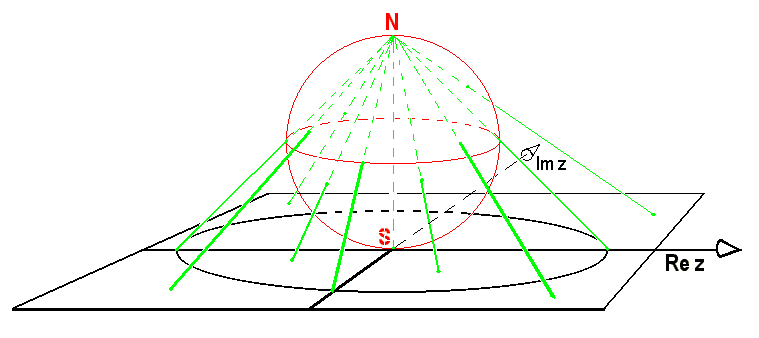
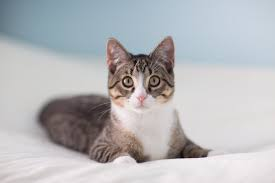

In [16]:
display(Markdown("# Erste Bilder von User:innen"))

d = user[user["no_images"] > 0]

result = []
result.append('<div style="width: 100%; display: flex; flex-flow: row wrap; justify-content: space-around;">')

for username in d.index:
    image = next(get_images(d.loc[username]["description"]))
    
    if image.startswith("/"):
        image = "https://de.serlo.org" + image
    
    user_id = d.loc[username]["id"]
    
    result.append('<div style="margin: 10px">')
    result.append(f'<img src="{image}" style="width: 100px;"/>')
    result.append(f'<p><a href="https://de.serlo.org/{user_id}">{username}</a></p>')
    result.append('</div>')

result.append('</div>')

display(HTML("\n".join(result)))

In [12]:
pd.read_sql("select user.id, user.date as register_date, user.username from user order by user.date desc limit 300;", db).to_csv("/tmp/new_user.csv")

In [13]:
user[user["no_images"] > 0][["id", "edits"]].to_csv("/tmp/user.csv")